## Check Points

- Out Activation
    - tanh to image, optional
    - sigmoid to discriminator, optional

- Visualized
    - output, o
    - gradients, o
    - loss, o
    - gcam, o
    - activation output, o

In [6]:
%%capture
!pip install git+https://github.com/crimson206/DataLoader@0.1.0
!pip install git+https://github.com/crimson206/DeepLearningDevelopment@0.1.8

In [2]:
import os
import pickle

# Define the path where the experiments are located
experiments_path = "basic_gans_experiment/"


In [21]:
# Get all the experiment directories
experiment_dirs = [f for f in os.listdir(experiments_path) if f.startswith('experiment')]

# Initialize a dictionary to hold the contents of the config_dict.pkl files
config_dicts = {}

# Loop through each experiment directory and load the config_dict.pkl file
for experiment_dir in experiment_dirs:
    config_path = os.path.join(experiments_path, experiment_dir, 'config_dict.pkl')
    if os.path.exists(config_path):
        with open(config_path, 'rb') as f:
            print(experiment_dir)
            print(pickle.load(f))

experiment0
{'n_latent': 128, 'generator_hidden_channels': [128, 256, 512, 1024], 'discriminator_hidden_channels': [784, 512, 256], 'generator_tanh': True, 'discriminator_sigmoid': True, 'negative_slope': 0.2}
experiment1
{'n_latent': 128, 'generator_hidden_channels': [128, 256, 512, 1024, 2048], 'discriminator_hidden_channels': [784, 1024, 512, 256], 'generator_tanh': True, 'discriminator_sigmoid': True, 'negative_slope': 0.2}
experiment1_2
{'n_latent': 128, 'generator_hidden_channels': [128, 256, 512], 'discriminator_hidden_channels': [784, 256], 'generator_tanh': True, 'discriminator_sigmoid': True, 'negative_slope': 0.2}
experiment2
{'n_latent': 128, 'generator_hidden_channels': [128, 256, 512, 1024], 'discriminator_hidden_channels': [784, 512, 256], 'generator_tanh': True, 'discriminator_sigmoid': False, 'negative_slope': 0.2}
experiment2_2
{'n_latent': 128, 'generator_hidden_channels': [128, 256, 512, 1024], 'discriminator_hidden_channels': [784, 512, 256], 'generator_tanh': Fals

## Experiments type (only two epochs)

- Experiment1
    Different hidden channels size

- Experiment2
    - Use tanh for generator output
    - Use sigmoid for discriminator output (BCELoss without sigmoid causes error. Replaced it by CrossEntropyLoss)
    * note: there is a naming issue. I used BCELoss for the majority

- Experiment3
    Flat hidden channels

- Experiment4
    Different n_latent


In [7]:
# Get all the experiment directories
experiment_dirs = [f for f in os.listdir(experiments_path) if f.startswith('long_training')]

# Initialize a dictionary to hold the contents of the config_dict.pkl files
config_dicts = {}

# Loop through each experiment directory and load the config_dict.pkl file
for experiment_dir in experiment_dirs:
    config_path = os.path.join(experiments_path, experiment_dir, 'config_dict.pkl')
    if os.path.exists(config_path):
        with open(config_path, 'rb') as f:
            print(experiment_dir)
            print(pickle.load(f))

long_training
{'n_latent': 256, 'generator_hidden_channels': [256, 256, 512, 1024], 'discriminator_hidden_channels': [784, 512, 256], 'generator_tanh': True, 'discriminator_sigmoid': True, 'negative_slope': 0.2}
long_training2
{'n_latent': 256, 'generator_hidden_channels': [256, 256, 512, 1024], 'discriminator_hidden_channels': [784, 512, 256], 'generator_tanh': True, 'discriminator_sigmoid': True, 'negative_slope': 0.2, 'initial_lr': 0.0005, 'scheduler_step': 1, 'scheduler_gamma': 0.95}


## Experiments type2

- Long Training1
    Used Experiment0 setup, but 20 epochs
    lr = 2e-4

- Long Training2
    Applied step scheduler. 
    lr, from 5e-4 to 6.4e-05

In [11]:
import torch
import torch.nn as nn
import pickle
import os
import time

import matplotlib.pyplot as plt

from torchvision.utils import save_image

import torch.optim as optim
from tqdm import tqdm
from IPython.display import clear_output

from CrimsonDataLoader.dataloads.dataloads import load_mnist
from CrimsonDeepLearning.visualization.loggers import Logger
from CrimsonDeepLearning.visualization.plot_grads import plot_gradient_magnitudes, get_gradient_magnitudes
from CrimsonDeepLearning.visualization.plot_general import plot_dictionary, plot_images
from CrimsonDeepLearning.visualization.plot_features import plot_gcam_2d, get_activation_visualization
from CrimsonDeepLearning.utils.randomness import seed_everything

class GeneratorBlock(nn.Module):
    def __init__(self, in_channel, out_channel, norm=True, negative_slope=0.2):
        super(GeneratorBlock, self).__init__()

        layers = []
        layers.append(nn.Linear(in_channel, out_channel))
        if norm:
            layers.append(nn.BatchNorm1d(out_channel))
        layers.append(nn.LeakyReLU(negative_slope, inplace=True))

        self.layers = nn.Sequential(*layers)

    def forward(self, input_tensor):
        return self.layers(input_tensor)

class Generator(nn.Module):
    def __init__(self, hidden_channels, negative_slope, tanh=True):
        super(Generator, self).__init__()

        layers = [
            GeneratorBlock(hidden_channels[i], hidden_channels[i+1], norm=False if i==0 else True, negative_slope=negative_slope)
            for i in range(len(hidden_channels)-1)
        ]

        self.layers = nn.Sequential(*layers)
        self.out_fc = nn.Linear(hidden_channels[-1], 1*28*28)
        self.tanh = tanh

    def forward(self, z_latent):
        output_tensor = z_latent

        output_tensor = self.layers(output_tensor)
        output_tensor = self.out_fc(output_tensor)
        output_tensor = output_tensor.view(output_tensor.size(0), 1, 28, 28)
        if self.tanh:
            output_tensor = nn.functional.tanh(output_tensor)
        return output_tensor

class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channel, out_channel, negative_slope):
        super(DiscriminatorBlock, self).__init__()

        layers = [
            nn.Linear(in_channel, out_channel),
            nn.LeakyReLU(negative_slope, inplace=True)
        ]

        self.layers = nn.Sequential(*layers)

    def forward(self, input_tensor):
        return self.layers(input_tensor)

class Discriminator(nn.Module):
    def __init__(self, hidden_channels, negative_slope, out_size=1, sigmoid=True):
        super(Discriminator, self).__init__()

        layers = [
            DiscriminatorBlock(hidden_channels[i], hidden_channels[i+1], negative_slope)
            for i in range(len(hidden_channels)-1)
        ]

        self.layers = nn.ModuleList(layers)
        self.out_fc = nn.Linear(hidden_channels[-1], out_size)
        self.sigmoid = sigmoid

    def forward(self, input_tensor):

        intermediate = input_tensor.flatten(1, -1)
        for layer in self.layers:
            intermediate = layer.forward(intermediate)

        if self.sigmoid:
            output = nn.functional.sigmoid(self.out_fc.forward(intermediate))
        else:
            output = self.out_fc.forward(intermediate)
        return output

## Experiment 0

Hidden Sizes

generator, [128, 256, 512, 1024]
discriminator, [28*28, 512, 256]

Output Activation

generator, tanh
discriminator, sigmoid



In [16]:
import torch
import io

import matplotlib.pyplot as plt

def plot_dictionary(data_dict, primary_axis_keys=[], second_axis_keys=[], title=None, 
                    figsize=(6, 4), xlabel='X-axis', primary_ylabel='Primary Y-axis', 
                    secondary_ylabel='Secondary Y-axis', primary_color='tab:blue', 
                    secondary_color='tab:red', primary_linestyle='-', secondary_linestyle='--'):
    """
    Plots curves from a dictionary of data using Matplotlib, with options for dual y-axes.
    
    Parameters:
    data_dict (dict): A dictionary where keys are the names of the data series 
                      and values are lists of data values.
    primary_axis_keys (list): List of keys to be plotted on the primary y-axis.
    second_axis_keys (list): List of keys to be plotted on a secondary y-axis.
    title (str, optional): Title of the plot.
    figsize (tuple): Size of the figure (width, height) in inches.
    xlabel (str): Label for the x-axis.
    primary_ylabel (str): Label for the primary y-axis.
    secondary_ylabel (str): Label for the secondary y-axis.
    primary_color (str): Color for the primary y-axis plots.
    secondary_color (str): Color for the secondary y-axis plots.
    primary_linestyle (str): Line style for the primary y-axis plots.
    secondary_linestyle (str): Line style for the secondary y-axis plots.
    """
    # Create a figure and a single subplot
    fig, ax1 = plt.subplots(figsize=figsize)

    if len(primary_axis_keys)==0:
        primary_axis_keys = data_dict.keys()

    # Plotting data on the primary y-axis
    for key, values in data_dict.items():
        if key in primary_axis_keys:
            if key not in second_axis_keys:
                ax1.plot(values, label=key, color=primary_color, linestyle=primary_linestyle)

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(primary_ylabel, color=primary_color)
    ax1.tick_params(axis='y', labelcolor=primary_color)

    # Handling the second y-axis
    if second_axis_keys:
        ax2 = ax1.twinx()
        for key in second_axis_keys:
            if key in data_dict:
                ax2.plot(data_dict[key], label=key, color=secondary_color, linestyle=secondary_linestyle)
        ax2.set_ylabel(secondary_ylabel, color=secondary_color)
        ax2.tick_params(axis='y', labelcolor=secondary_color)

    # Title and legend
    if title:
        plt.title(title)
    fig.tight_layout()
    ax1.legend(loc='upper left')
    if second_axis_keys:
        ax2.legend(loc='upper right')

    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    plt.show()
    plt.close()
    return buffer.getvalue()

In [15]:
def plot_gradient_magnitudes(grad_magnitudes, title=None):
    layer_names = list(grad_magnitudes.keys())
    magnitudes = list(grad_magnitudes.values())

    plt.bar(layer_names, magnitudes)
    plt.xlabel('Layers')
    plt.ylabel('Gradient Magnitude')
    if title is None:
        title = 'Gradient Magnitudes per Layer'
    plt.title(title)
    plt.xticks(rotation=90)

    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    plt.show()
    plt.close()
    return buffer.getvalue()


In [14]:
def handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir):

    clear_output()
    loss_logger.epoch_step()
    plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"], primary_ylabel="Loss", secondary_ylabel="Time")
    plot_images(fake_image.detach())

    os.makedirs(save_dir, exist_ok=True)
    save_image(fake_image.data[:25], f"{save_dir}/generated_image_{done}.png", nrow=5, normalize=True)

    dis_grad_dict = get_gradient_magnitudes(discriminator)
    dis_grad_png = plot_gradient_magnitudes(dis_grad_dict, title="Discriminator Gradients")
    gen_grad_dict = get_gradient_magnitudes(generator)
    gen_grad_png = plot_gradient_magnitudes(gen_grad_dict, title="Generator Gradients")

    file_path = f"{save_dir}/discriminator_gradient_magnitudes_{done}.png"
    with open(file_path, "wb") as file:
        file.write(dis_grad_png)
    file_path = f"{save_dir}/generator_gradient_magnitudes_{done}.png"
    with open(file_path, "wb") as file:
        file.write(gen_grad_png)

In [13]:
def step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device):
    n_batch = image.shape[0]

    real_label = torch.ones(n_batch, 1).float().to(device)
    fake_label = 0 * real_label

    ### Prepare random noraml distribution

    z_latent = torch.randn(n_batch, n_latent).to(device)
    #z_latent = torch.normal(mean=0, std=1, size=(n_batch, n_latent))
    ### Prepare images

    real_image = image.to(device)
    fake_image = generator.forward(z_latent).detach()

    ### Train discriminator

    real_output = discriminator.forward(real_image)
    fake_output = discriminator.forward(fake_image)

    real_loss_D = cross_entropy_loss.forward(real_output, real_label)
    fake_loss_D = cross_entropy_loss.forward(fake_output, fake_label)

    loss_D = 0.5*real_loss_D + 0.5*fake_loss_D

    discriminator.zero_grad()
    loss_D.backward()
    optim_D.step()

    ### Train Generator

    fake_image = generator.forward(z_latent)

    deceived_output = discriminator.forward(fake_image)

    loss_G = - cross_entropy_loss.forward(deceived_output, fake_label)

    generator.zero_grad()
    loss_G.backward()

    optim_G.step()

    loss_D = real_loss_D + fake_loss_D
    current_time = time.time()

    time_spent = current_time - start_time

    loss_logger.batch_step([loss_D.clamp(0, 5).detach().item(), loss_G.clamp(-1, 0).detach().item(), time_spent], ["Loss D", "Loss G", "Time"])

    return fake_image

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

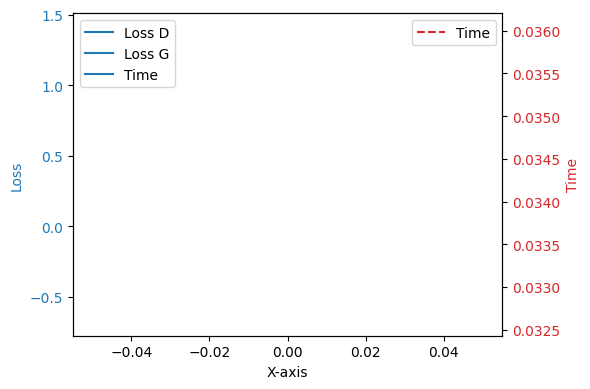

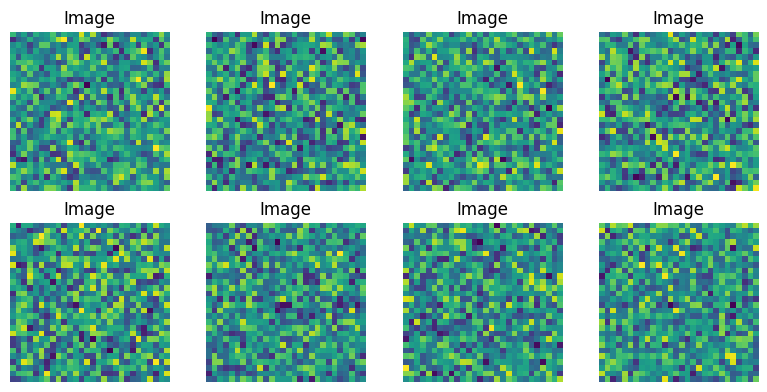

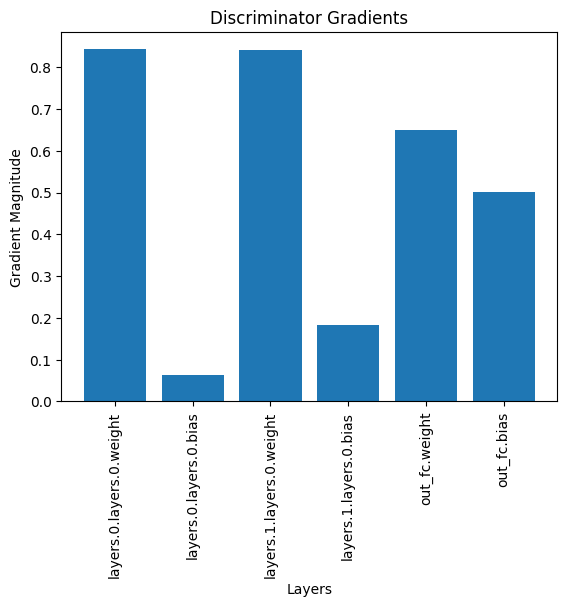

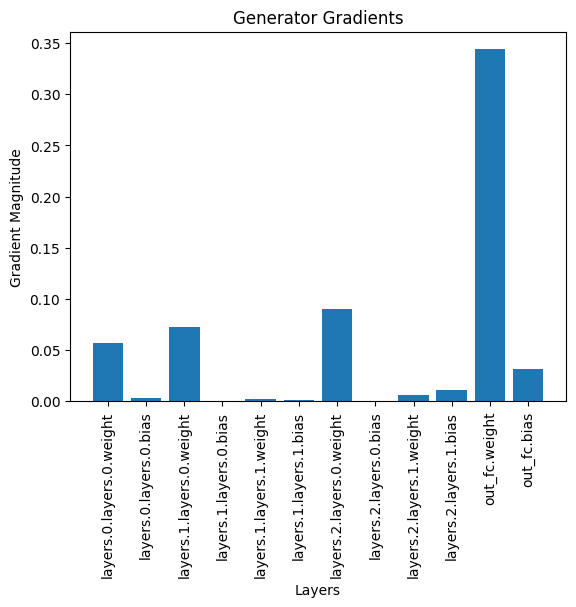

  0%|          | 0/1875 [00:01<?, ?it/s]


TypeError: a bytes-like object is required, not 'NoneType'

In [21]:
exp_name = "experiment0"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 256, 512, 1024],
    "discriminator_hidden_channels": [28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 2
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)


n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)


loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

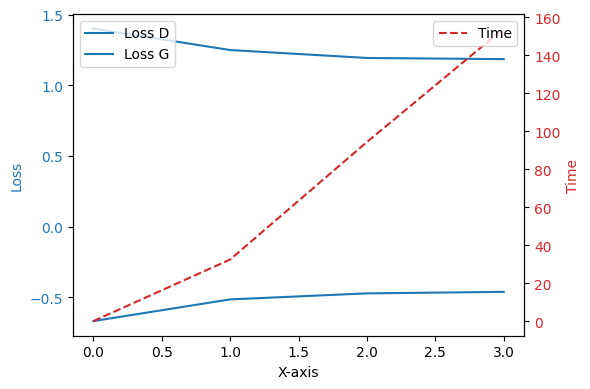

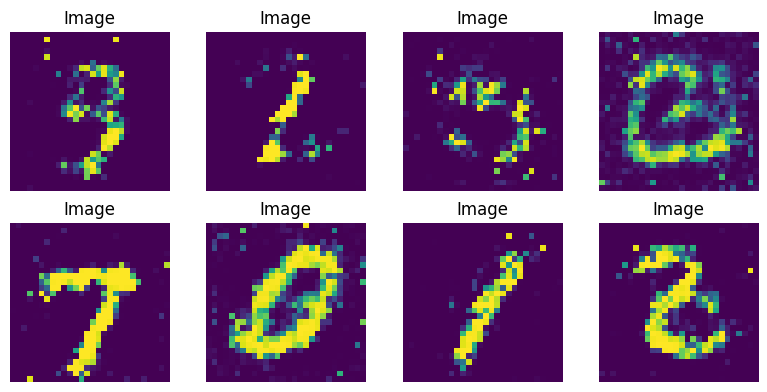

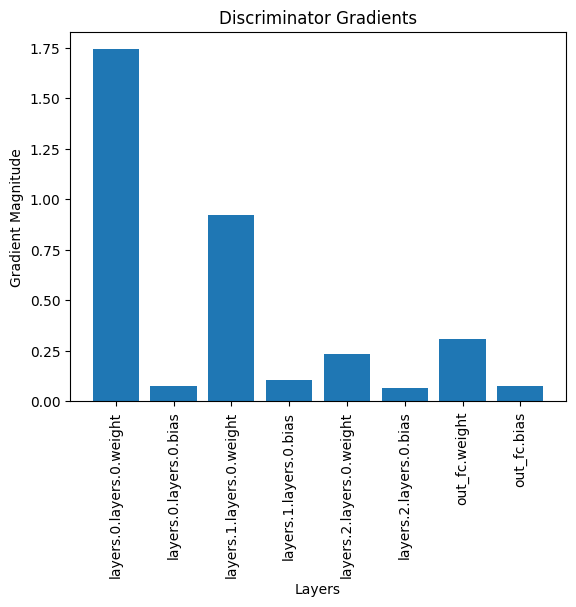

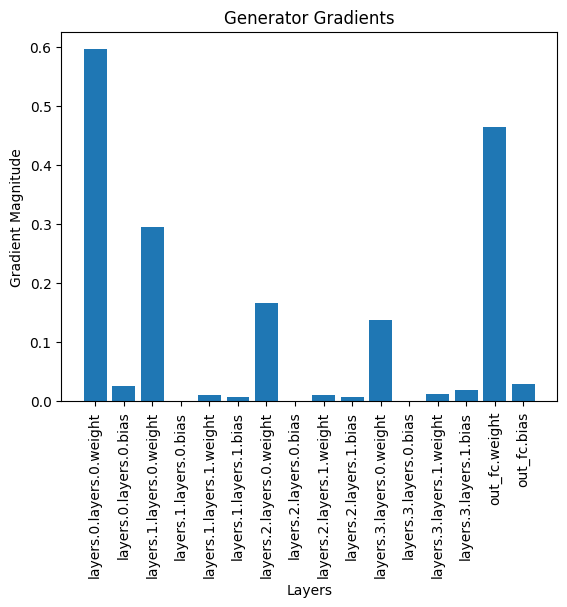

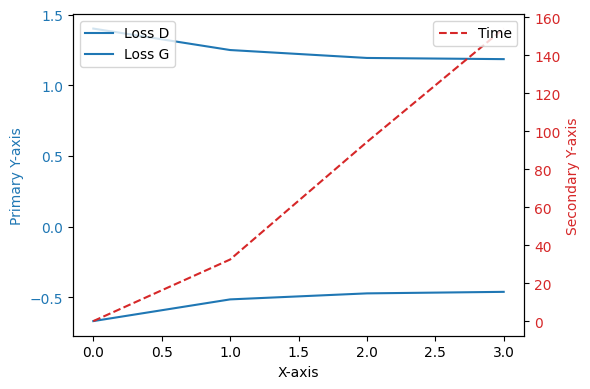

In [27]:
exp_name = "experiment1"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 256, 512, 1024, 2048],
    "discriminator_hidden_channels": [28*28, 1024, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 2
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)


n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)

loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

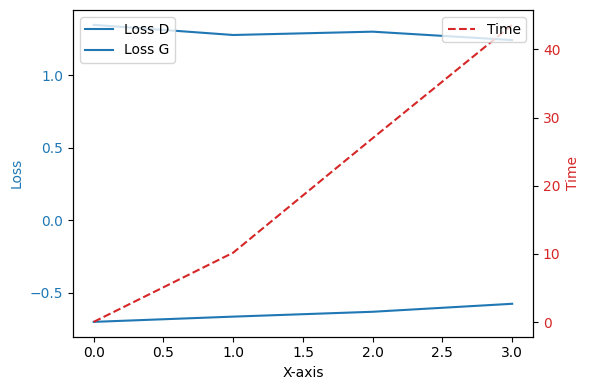

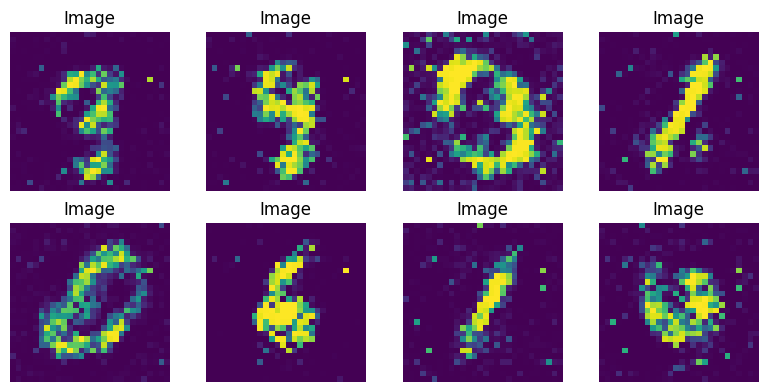

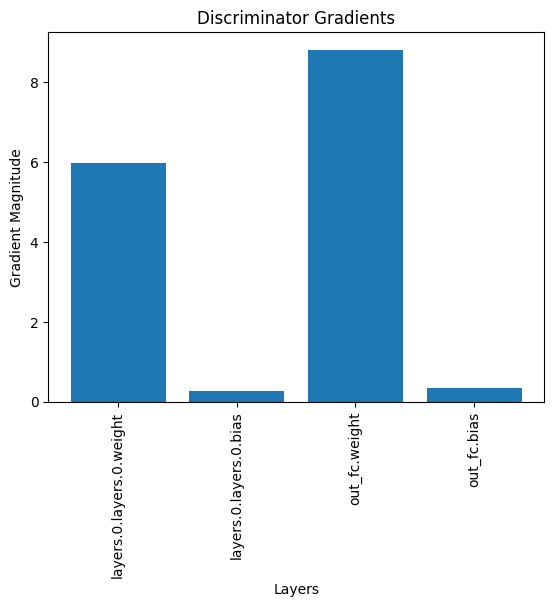

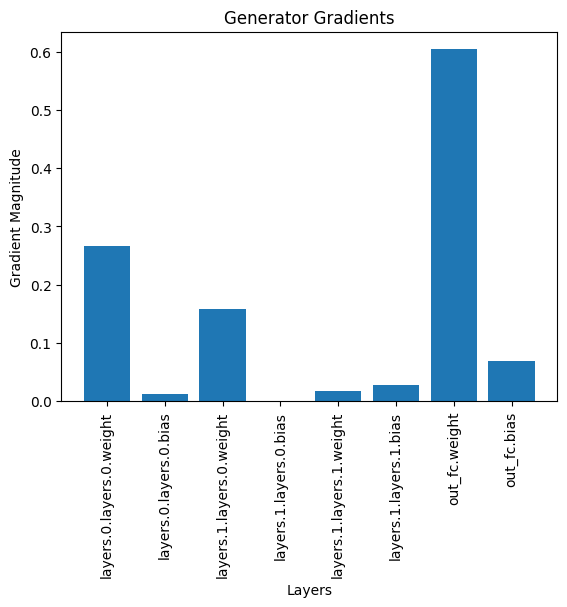

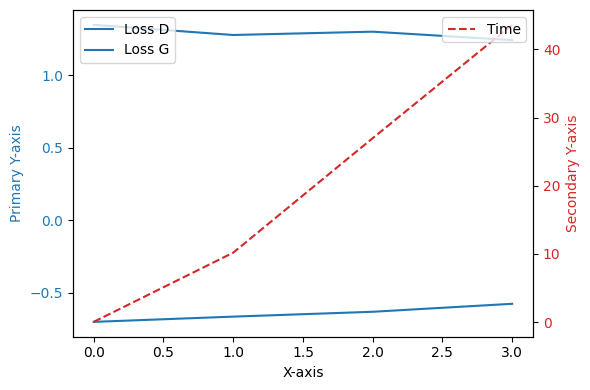

In [28]:
exp_name = "experiment1_2"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 256, 512, 1024],
    "discriminator_hidden_channels": [28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":False,
    "negative_slope":0.2,
    "crossentropy":True
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 2
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)


n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)

loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

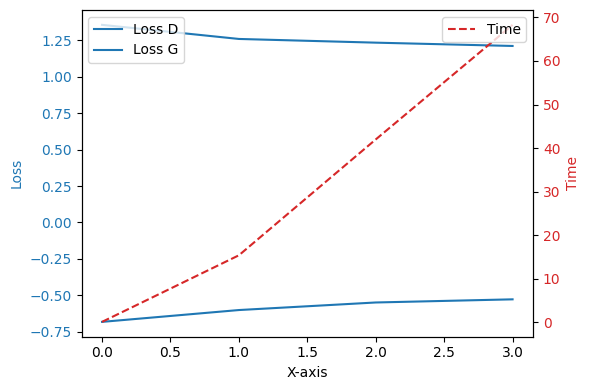

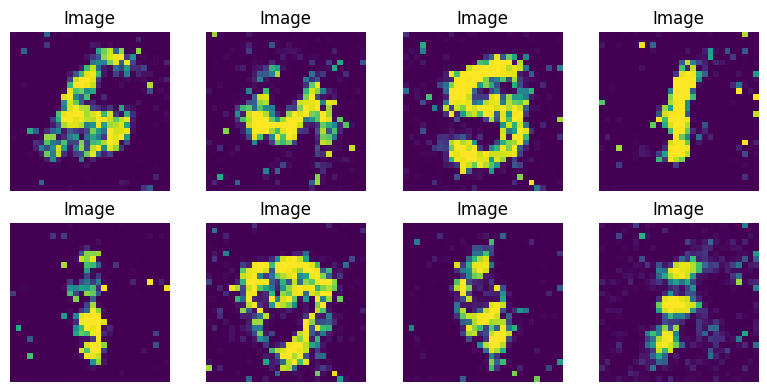

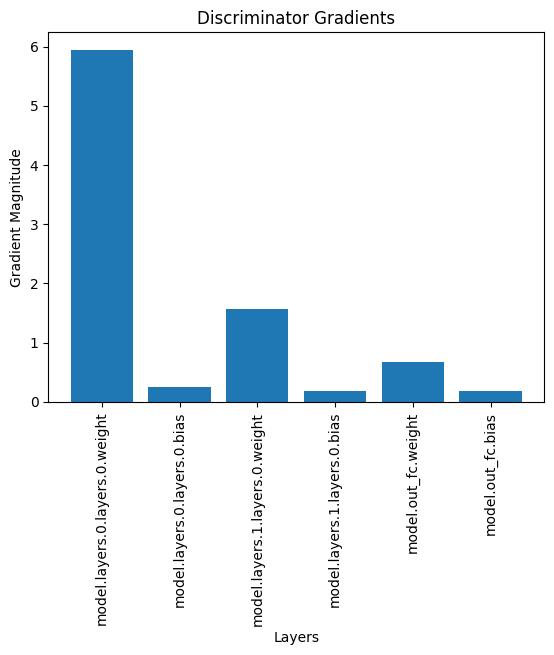

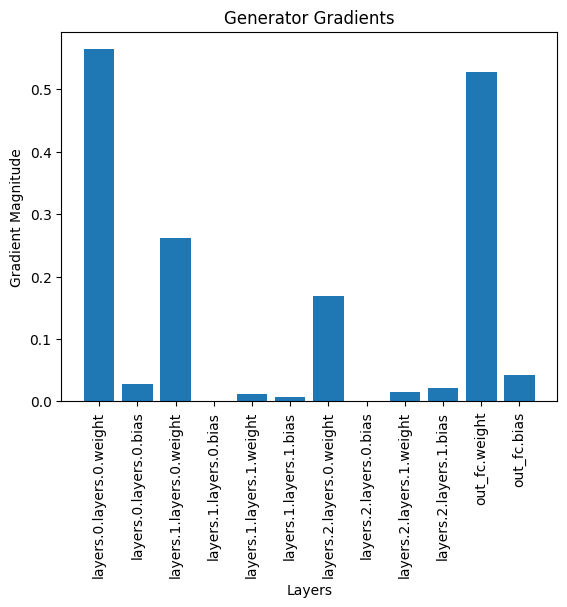

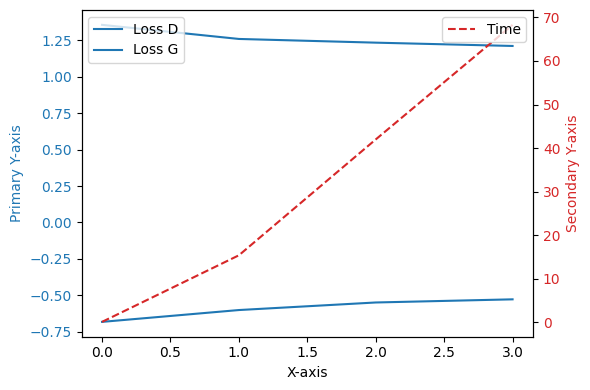

In [18]:
exp_name = "experiment2_3"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 256, 512, 1024],
    "discriminator_hidden_channels": [28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":False,
    "negative_slope":0.2,
    "crossentropy_and_soft_max":True
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 2
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid, out_size=2).to(device)

class SoftmaxEncapsul(nn.Module):
    def __init__(self, model):
        super(SoftmaxEncapsul, self).__init__()

        self.model = model
    
    def forward(self, input_tensor):
        return nn.functional.softmax(self.model(input_tensor), dim=1)

discriminator = SoftmaxEncapsul(discriminator)

n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.CrossEntropyLoss()

class CustomLoss(nn.Module):
    def __init__(self, criterion):
        super(CustomLoss, self).__init__()

        self.criterion = criterion
    
    def forward(self, pred, label):
        label = label.squeeze(-1).long()
        return self.criterion(pred, label)
cross_entropy_loss = CustomLoss(cross_entropy_loss)

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)


loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)


In [38]:
generator.layers

Sequential(
  (0): GeneratorBlock(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (1): GeneratorBlock(
    (layers): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (2): GeneratorBlock(
    (layers): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
)

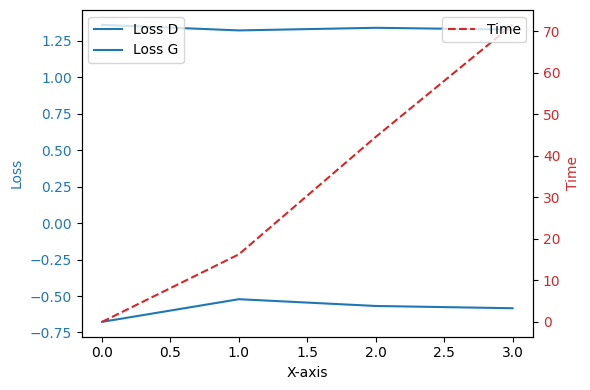

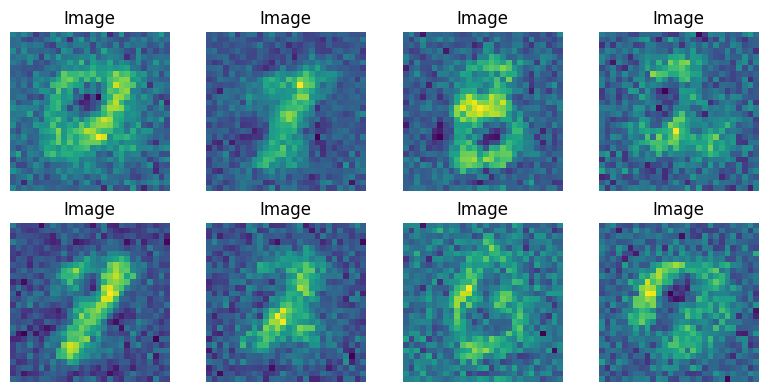

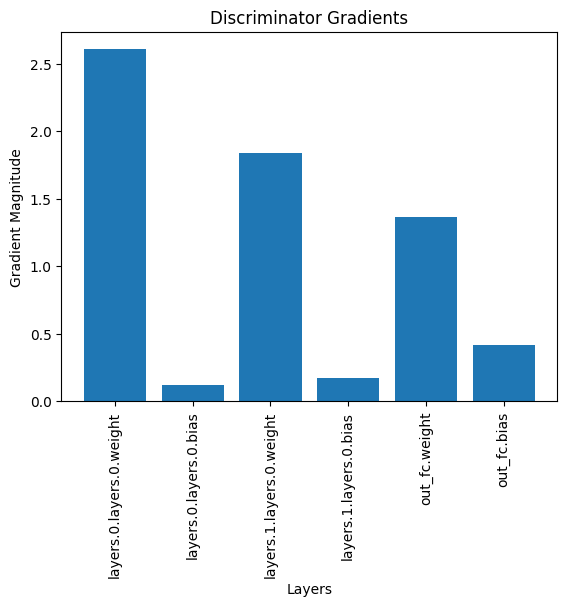

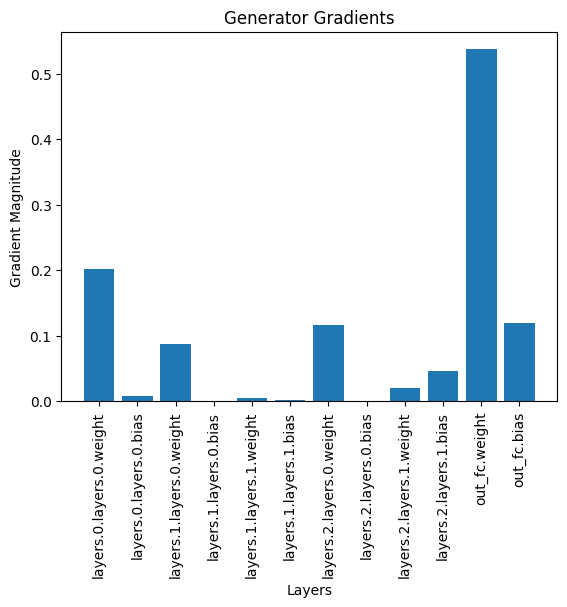

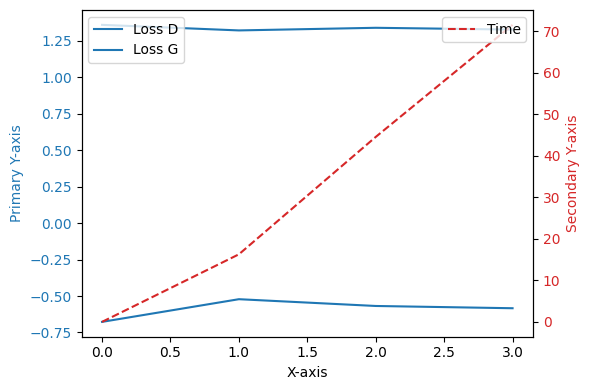

In [42]:
exp_name = "experiment2_2"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 256, 512, 1024],
    "discriminator_hidden_channels": [28*28, 512, 256],
    "generator_tanh":False,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
    "crossentropy":True
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 2
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)


n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)


loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

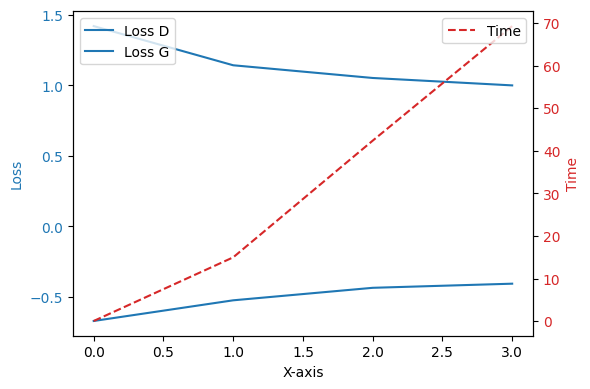

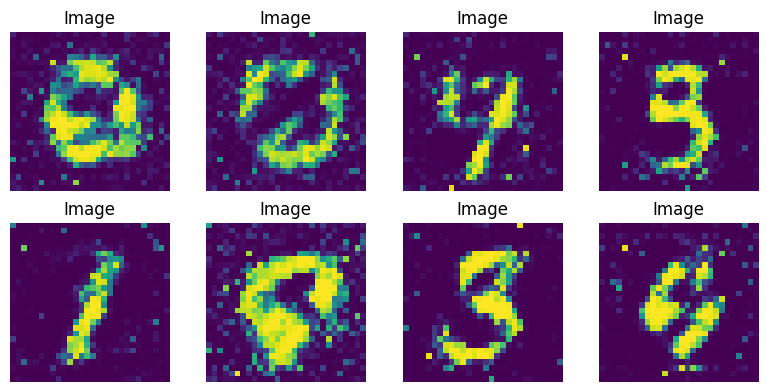

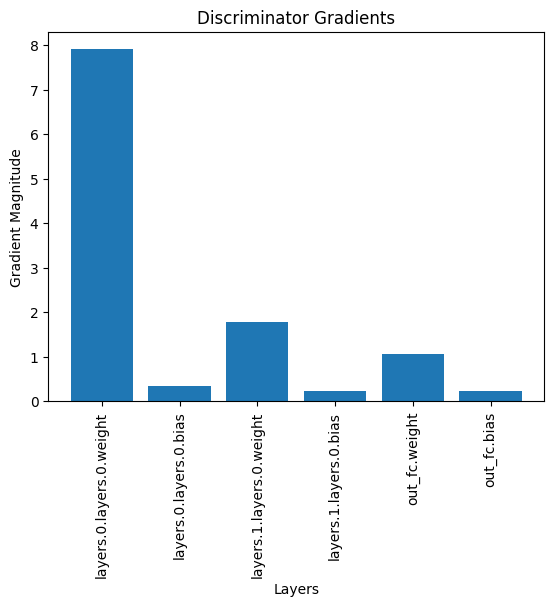

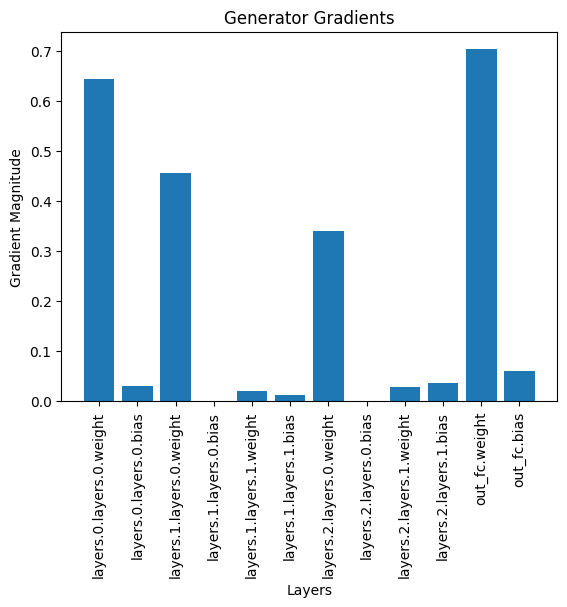

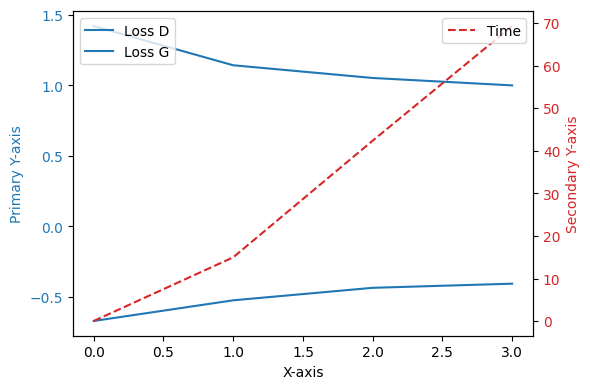

In [44]:
exp_name = "experiment3"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":128,
    "generator_hidden_channels": [128, 512, 512, 512],
    "discriminator_hidden_channels": [28*28, 512, 512],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 2
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)


n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)


loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

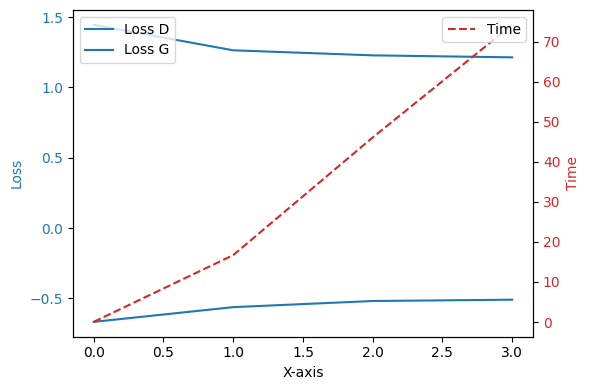

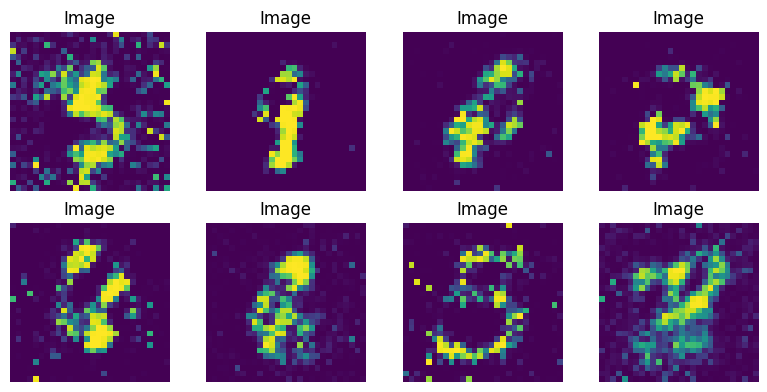

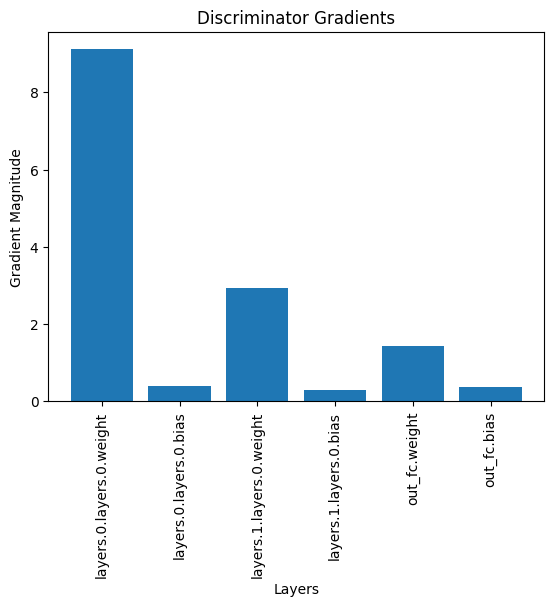

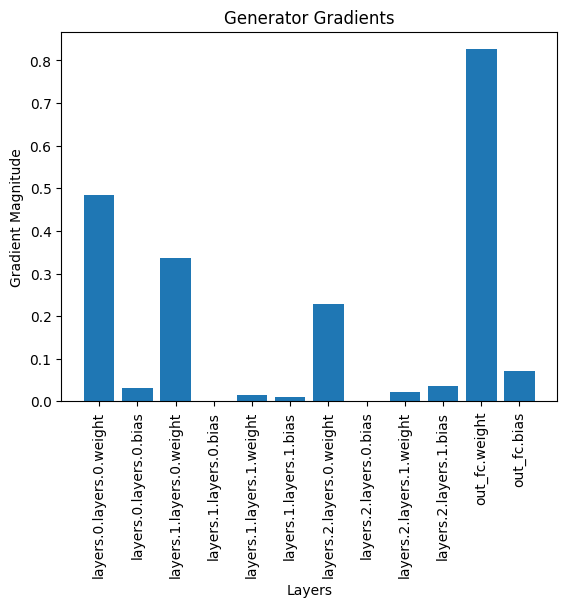

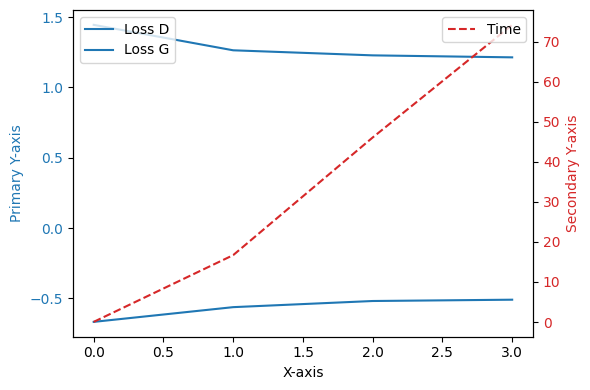

In [46]:
exp_name = "experiment4"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":64,
    "generator_hidden_channels": [64, 256, 512, 1024],
    "discriminator_hidden_channels": [28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 2
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)


n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)


loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

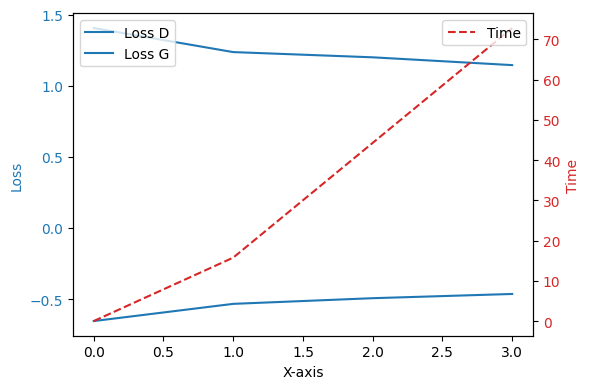

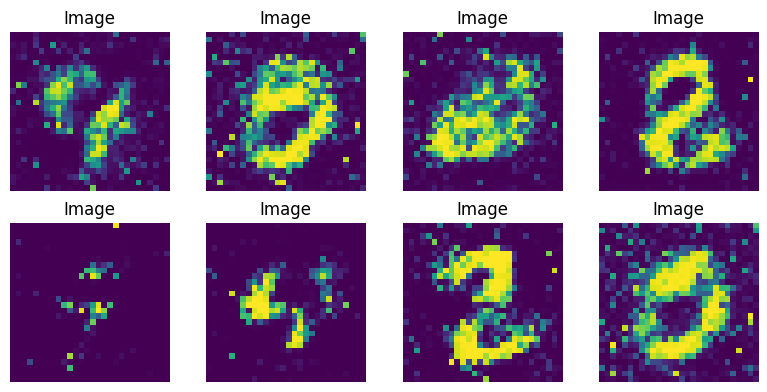

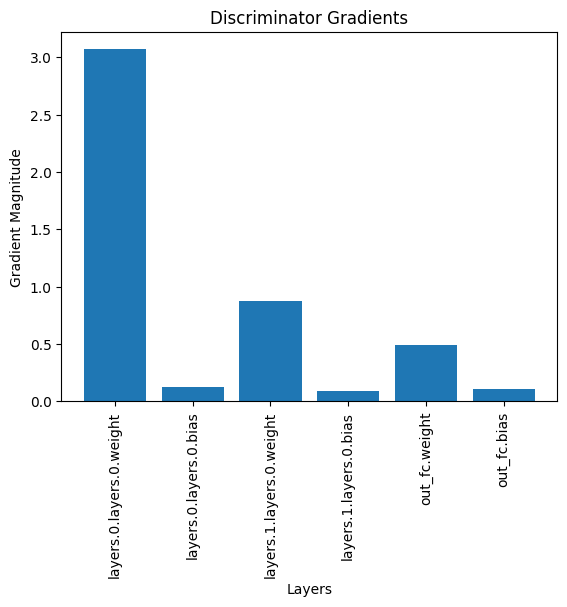

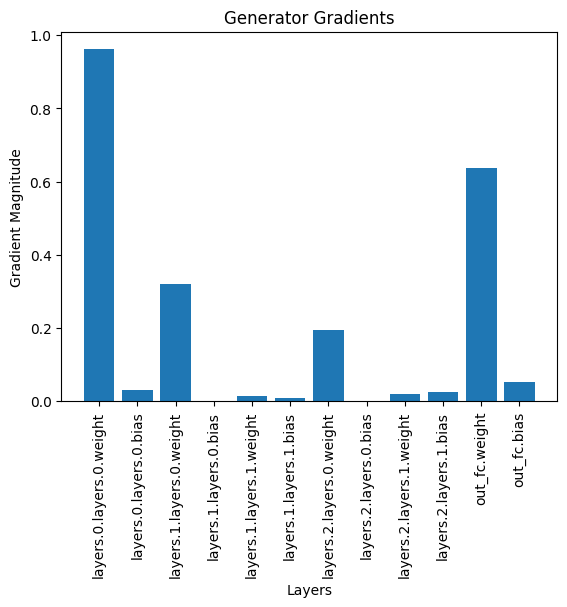

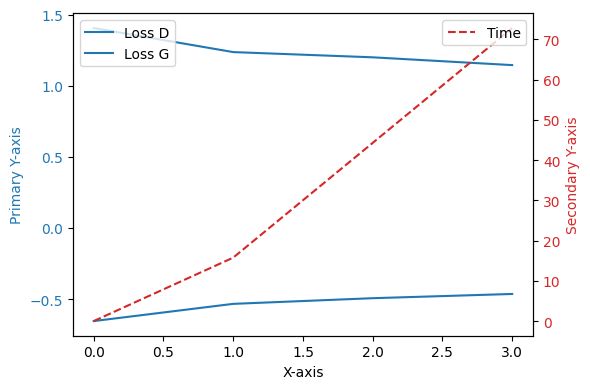

In [47]:
exp_name = "experiment4_2"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":256,
    "generator_hidden_channels": [256, 256, 512, 1024],
    "discriminator_hidden_channels": [28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 2
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)


n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)

loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

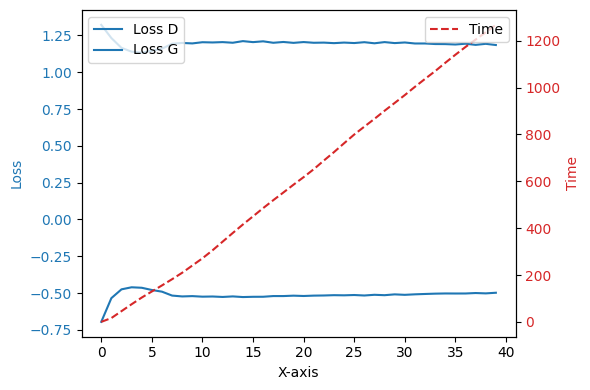

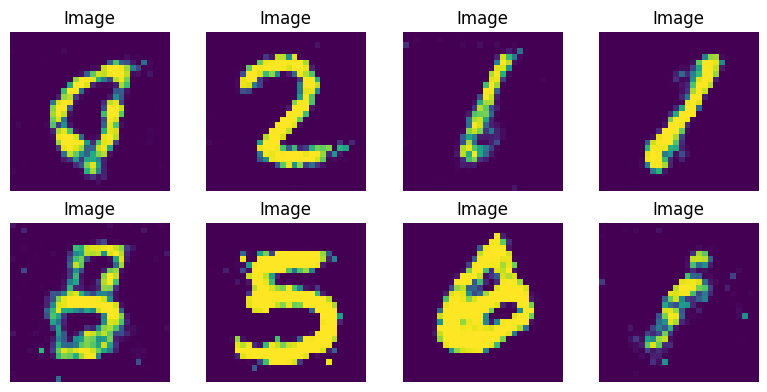

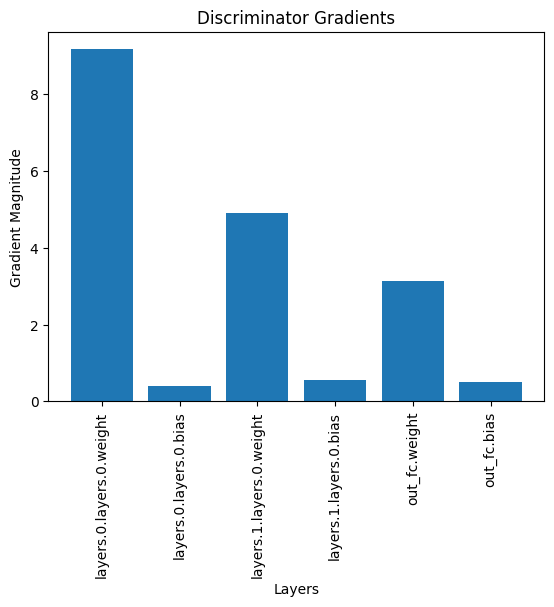

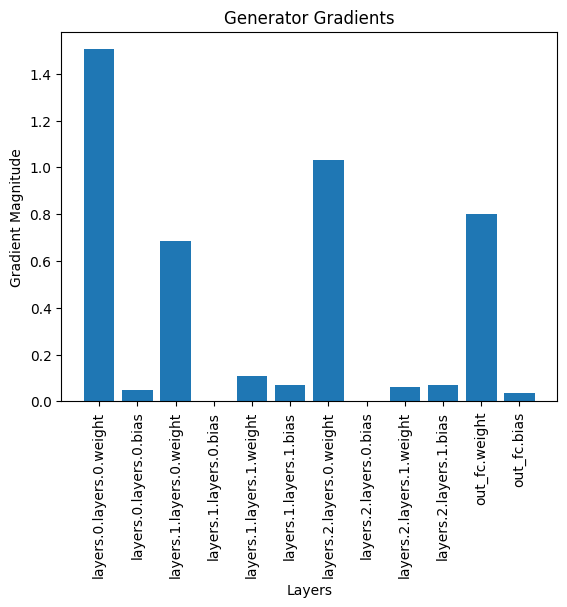

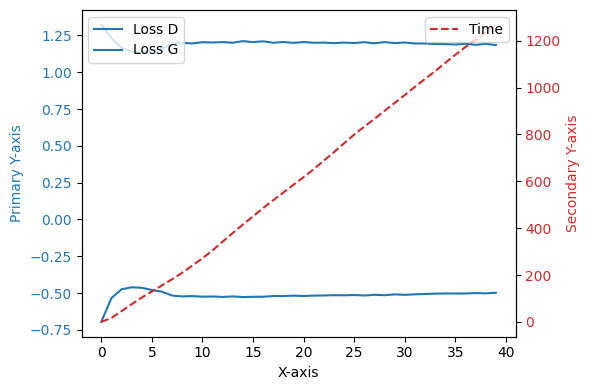

In [48]:
exp_name = "long_training"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":256,
    "generator_hidden_channels": [256, 256, 512, 1024],
    "discriminator_hidden_channels": [28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 20
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)

n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)

loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

In [55]:
0.9**20

0.12157665459056935

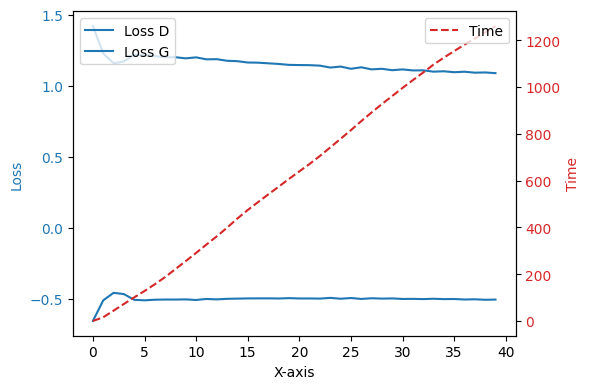

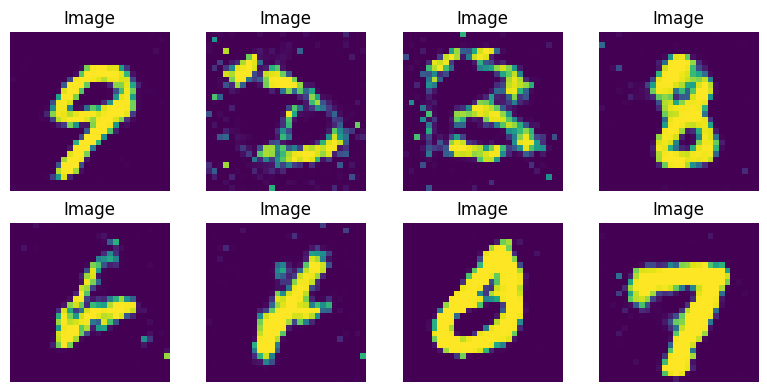

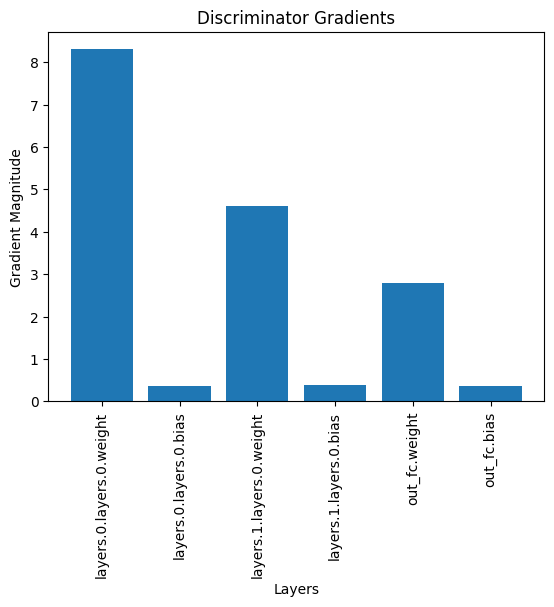

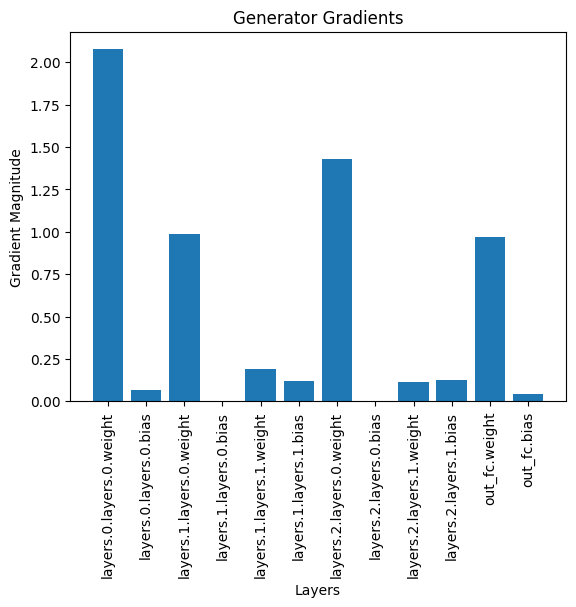

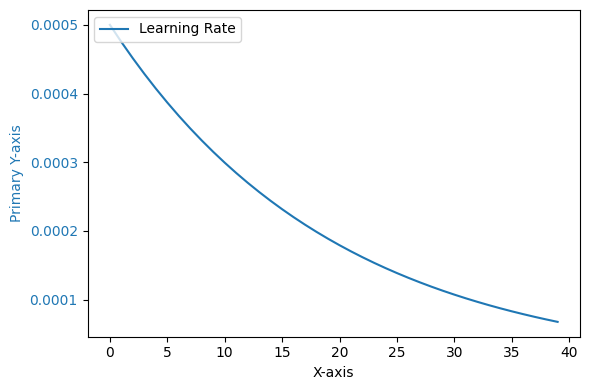

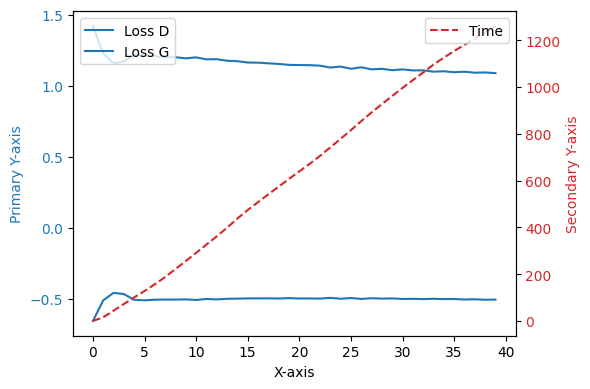

In [57]:
exp_name = "long_training2"
save_dir = f"basic_gans_experiment/{exp_name}"

config_dict = {
    "n_latent":256,
    "generator_hidden_channels": [256, 256, 512, 1024],
    "discriminator_hidden_channels": [28*28, 512, 256],
    "generator_tanh":True,
    "discriminator_sigmoid":True,
    "negative_slope":0.2,
    "initial_lr":0.0005,
    "scheduler_step":1,
    "scheduler_gamma":0.95,
}

n_latent = config_dict["n_latent"]
generator_hidden_channels = config_dict["generator_hidden_channels"]
discriminator_hidden_channels = config_dict["discriminator_hidden_channels"]

generator_tanh = config_dict["generator_tanh"]
discriminator_sigmoid = config_dict["discriminator_sigmoid"]

negative_slope= config_dict["negative_slope"]

epochs = 20
checking_interval = 1000

generator = Generator(hidden_channels=generator_hidden_channels, negative_slope=negative_slope, tanh=generator_tanh).to(device)
discriminator = Discriminator(hidden_channels=discriminator_hidden_channels, negative_slope=negative_slope, sigmoid=discriminator_sigmoid).to(device)

n_batch = 32

train_dataset, train_loader, _, _ = load_mnist(batch_size=n_batch)

loss_logger = Logger()
lr_logger = Logger()

optim_D = optim.Adam(discriminator.parameters(), lr=config_dict["initial_lr"], betas=(0.5, 0.999))
optim_G = optim.Adam(generator.parameters(), lr=config_dict["initial_lr"], betas=(0.5, 0.999))

scheduler_D = torch.optim.lr_scheduler.StepLR(optim_D, step_size=config_dict["scheduler_step"], gamma=config_dict["scheduler_gamma"])
scheduler_G = torch.optim.lr_scheduler.StepLR(optim_G, step_size=config_dict["scheduler_step"], gamma=config_dict["scheduler_gamma"])

cross_entropy_loss = nn.BCELoss()

progress_bar = tqdm(train_loader)

start_time = time.time()
for epoch in range(epochs):
    for i, (image, _) in enumerate(progress_bar):

        fake_image= step_batch(discriminator, generator, optim_D, optim_G, n_latent, start_time, loss_logger, i, image, cross_entropy_loss, device)
        
        done = epoch * len(train_loader) + i

        if i%checking_interval==0:
            handle_checkpoint(generator, discriminator, loss_logger, fake_image, done, save_dir)
            lr_logger.batch_step(values = [optim_D.param_groups[0]["lr"]], labels = ["Learning Rate"])
            plot_dictionary(lr_logger.batch_values_dict)
            scheduler_D.step()
            scheduler_G.step()

loss_png = plot_dictionary(loss_logger.epoch_values_dict, second_axis_keys=["Time"])
with open(f"{save_dir}/loss_history.png", "wb") as file:
    file.write(loss_png)
with open(f'{save_dir}/config_dict.pkl', 'wb') as pickle_file:
    pickle.dump(config_dict, pickle_file)

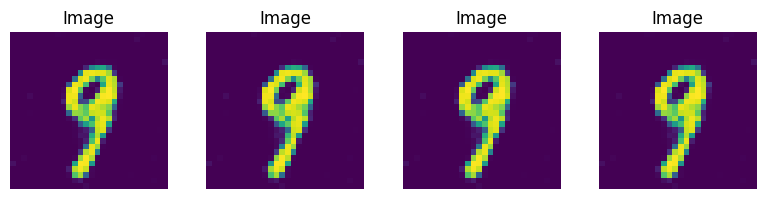

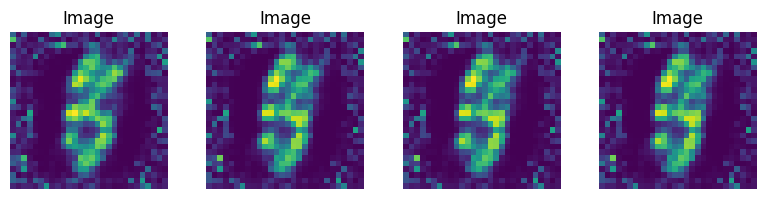

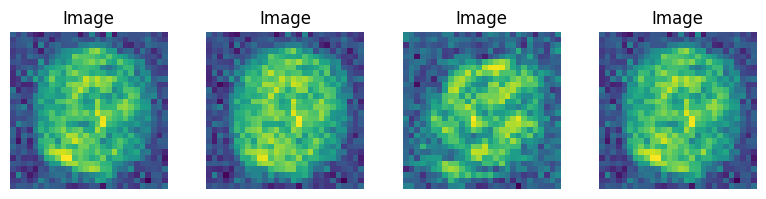

In [58]:
model = generator

for i in range(3):
    layer_to_modify = generator.layers[i]
    channel_to_activate = 10

    seed_everything(42)
    z_latent = torch.randn(n_batch, n_latent)
    output = get_activation_visualization(model, layer_to_modify, z_latent, channel_to_activate)
    plot_images(output, rows=1 , cols=4)

0


c:\Users\sisun\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


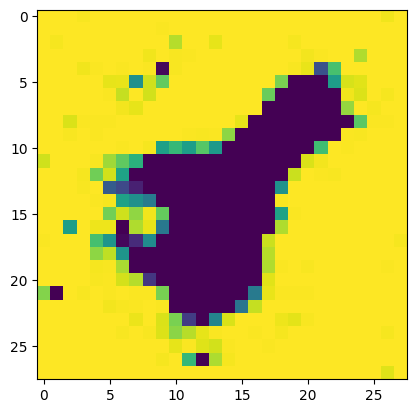

1


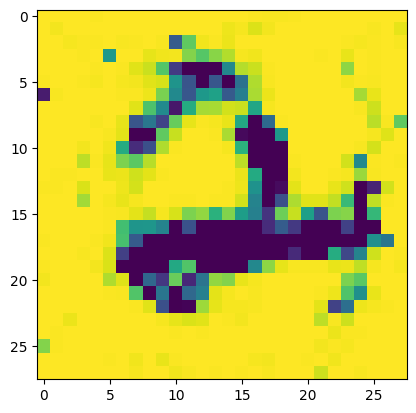

2


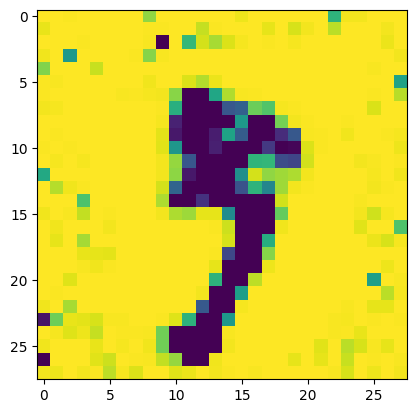

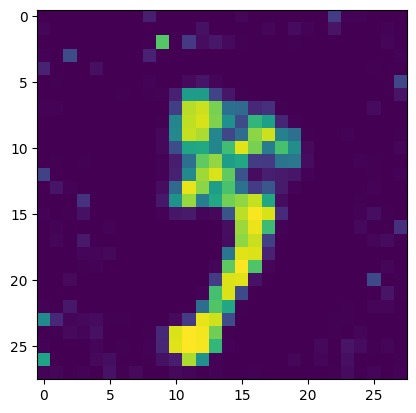

In [60]:
class Connected(nn.Module):
    def __init__(self, discriminator):
        super(Connected, self).__init__()
        self.dummy_conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=1)
        self.discriminator = discriminator

        nn.init.constant_(self.dummy_conv.weight, 1)
        nn.init.constant_(self.dummy_conv.bias, 0)

    def forward(self, fake_image):
        fake_image = self.dummy_conv(fake_image).mean(dim=1)
        fake_output = self.discriminator.forward(fake_image)
        return fake_output

seed_everything(42)
z_latent =torch.randn(32, 256)

connected = Connected(discriminator=discriminator)
dummy_conv = connected.dummy_conv

for i in range(3):
    fake_image = generator(z_latent)
    fake_image.requires_grad_(True)

    print(i)
    plot_gcam_2d(dummy_conv, i, fake_image, connected)
    plt.imshow(fake_image[i, ...].permute(1, 2, 0).detach())